In [1]:
import os
import sys
import warnings
import time

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
warnings.simplefilter("ignore")

import tensorflow as tf
import numpy as np

from tqdm import tqdm
from pympler import asizeof
from humanize import naturaldelta, naturalsize
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import mixed_precision

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using device: {physical_devices[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU device found, using CPU")

from eda import show_images
from models import create_dataset_from_mapping, compute_mean_std, get_transform, reverse_transform

Using device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-06-02 16:58:07.403687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-02 16:58:07.403707: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-02 16:58:07.403710: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-02 16:58:07.403724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 16:58:07.403735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Dataset creation

Below code calculates mean and std for images from training set, that will be used later in CustomImagedataset to normalize images

In [2]:
# dataset = create_dataset_from_mapping(mapping_file="train_mapping.csv")

# dataset = dataset.batch(128).prefetch(tf.data.AUTOTUNE)
# mean, std = compute_mean_std(dataset)
# print(f"Mean: {mean}, Std: {std}")

# Feature extractor

## EfficientNet

We'll use EfficientNet CNN part as feature extractor, thus it has been proven to be relatively fast. We choose b3 option as best balance between model response time and model complexity (measured as performance on ImageNet 21k on which it has been trained on - we choose it over ImageNet 1k believing it will learn patterns that might generalize better for our - still far away from close to ImageNet - photos)

More on EfficientNet we've choosen [here](https://huggingface.co/timm/tf_efficientnetv2_b3.in21k)

In [3]:
base_model = EfficientNetB3(weights='imagenet', include_top=False)
base_model.trainable = False

feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

Even though it has been trained on 240x240 images it accepts other image sizes so we'll keep our 150x150 as input.

Limited by our PCs we choose to stick with small batch size. Many papers also suggest that smaller batch sizes tend to lower the amount of epochs neaded for model to learn the underlaying data.

In [4]:
dataset = create_dataset_from_mapping(mapping_file="train_mapping.csv", transform=get_transform())

batch_size = 16
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

example_batch = next(iter(dataset))
example_image = example_batch[0]
example_image = example_image[np.newaxis, ...]

In [5]:
example_batch.shape

TensorShape([16, 150, 150, 3])

EfficientNet from each image extacts tensor of 1536 * 4 * 4 features, leading to 1 - (1536 * 4 * 4) / (150 * 150 * 3) ~= 64% data compression rate on first step

In [6]:
f = feature_extractor.predict(example_image)
f.shape

2024-06-02 16:58:10.652500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(1, 4, 4, 1536)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79120606..-0.7219493].


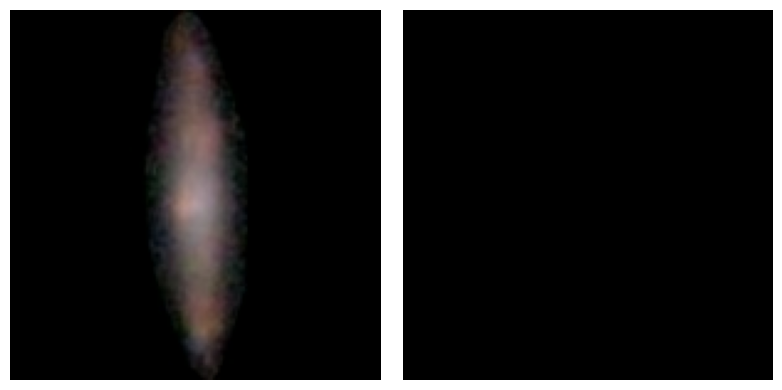

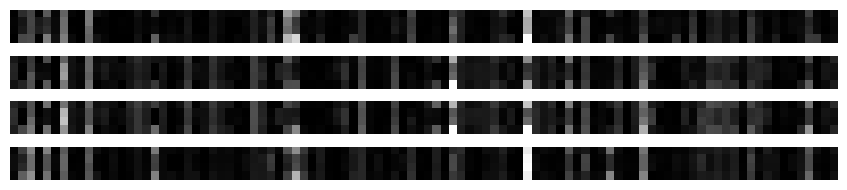

In [7]:
images = [reverse_transform(example_image), example_image[0].numpy()]
sample_features_small = f[0][:, :, :100]

show_images(images, ncols=2)
show_images(sample_features_small, cmap="gray", ncols=1, figsize=(10,  2))

In [8]:
del dataset
del f
del example_batch
del images

## SimCLR

[paper](https://arxiv.org/pdf/2002.05709)

In [9]:
def get_model(input_dim, hidden_dims, output_dim):
    hidden_dims.append(output_dim)
    last_size = input_dim

    hidden = [
        layers.GlobalAveragePooling2D(),
    ]

    for hidden_size in hidden_sizes:
        hidden.extend([
            layers.Dense(hidden_size, activation='gelu'),
            layers.BatchNormalization()
        ])

    return models.Sequential(hidden)

def nt_xent_loss(out_1, out_2, temperature):
    out_1 = tf.nn.l2_normalize(out_1, axis=1)
    out_2 = tf.nn.l2_normalize(out_2, axis=1)
    batch_size = tf.shape(out_1)[0]
    
    out = tf.concat([out_1, out_2], axis=0)
    sim_matrix = tf.exp(tf.matmul(out, tf.transpose(out)) / temperature)
    mask = tf.logical_not(tf.eye(2 * batch_size, dtype=tf.bool))
    sim_matrix = tf.boolean_mask(sim_matrix, mask)

    pos_sim = tf.exp(tf.reduce_sum(out_1 * out_2, axis=-1) / temperature)
    pos_sim = tf.concat([pos_sim, pos_sim], axis=0)

    loss = -tf.reduce_mean(tf.math.log(pos_sim / tf.reduce_sum(sim_matrix, axis=-1)))
    return loss

In [10]:
feature_in_size = 1536 * 5 * 5
hidden_sizes = [8192, 4096]
feature_out_size = 1024

model = get_model(input_dim=feature_in_size, hidden_dims=hidden_sizes, output_dim=feature_out_size)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d        │ (16, 1536)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 256)              │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (16, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (16, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (16, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (16, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,128 (2.01 MB)

 Trainable params: 526,592 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [11]:
print(f"Model size: {naturalsize(asizeof.asizeof(model))}")

Model size: 55.4 kB


## Training

In [16]:
train_batch_size = 16
valid_batch_size = 128

train_dataset = create_dataset_from_mapping(mapping_file="train_mapping.csv", transform=get_transform(train=True))
valid_dataset = create_dataset_from_mapping(mapping_file="validation_mapping.csv", transform=get_transform())


train_dataset = train_dataset.shuffle(buffer_size=1024).batch(train_batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.shuffle(buffer_size=1024).batch(valid_batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
num_epochs = 100
lr = 1e-3

optimizer = optimizers.Adam(learning_rate=lr)

In [18]:
temperature = 0.5

log_interval = 10
early_stopping_patience = 10
best_val_loss = np.inf
patience_counter = 0
best_model_state = None

In [19]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

train_losses = []
val_losses = []

best_val_loss = np.inf
patience_counter = 0

master_t0 = time.time()
for epoch in range(num_epochs):
    # Training phase
    train_loss = 0
    train_t0 = time.time()
    train_dataloader = tqdm(train_dataset, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for batch_idx, data in enumerate(train_dataloader):
        with tf.GradientTape() as tape:
            features = feature_extractor(data)
            out_1 = model(features, training=True)
            out_2 = model(features)
            loss = nt_xent_loss(out_1, out_2, temperature)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss += loss.numpy()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    print(f"\nTraining phase completed for epoch {epoch+1}, took {naturaldelta(time.time() - train_t0)}.")

    # Validation phase
    val_loss = 0    
    with tf.device(device):
        valid_t0 = time.time()
        valid_dataloader = tqdm(valid_dataset, desc="Validation", unit="batch")
        for data in valid_dataloader:
            features = feature_extractor.predict(data)
            out_1 = model.predict(features)
            out_2 = model.predict(features)
            loss = nt_xent_loss(out_1, out_2, temperature)
            val_loss += loss.numpy()

    val_loss /= len(valid_dataset)
    val_losses.append(val_loss)

    print(f"\nValidation phase completed for epoch {epoch+1}, took {naturaldelta(time.time() - valid_t0)}.")

    print(
        f"====> Epoch: {epoch+1}, Average training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}. "
        f"Execution time: {naturaldelta(time.time() - train_t0)}.\n"
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model state
        best_model_state = {
            "encoder": encoder.get_weights(),
            "projection_head": projection_head.get_weights(),
            "optimizer": optimizer.get_weights(),
        }
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered. Restoring best model state.")
            encoder.set_weights(best_model_state["encoder"])
            projection_head.set_weights(best_model_state["projection_head"])
            optimizer.set_weights(best_model_state["optimizer"])
            break

# Save model and training history
tf.keras.models.save_model(encoder, 'encoder_model.h5')
tf.keras.models.save_model(projection_head, 'projection_head_model.h5')
np.save("train_losses.npy", np.array(train_losses))
np.save("val_losses.npy", np.array(val_losses))

print(f"\nTraining complete. Took {naturaldelta(time.time() - master_t0)}.")


Epoch 1/100:   0%|          | 11/3081 [00:35<2:47:25,  3.27s/batch]


KeyboardInterrupt: 